In [1]:
import matplotlib.pyplot as plt, multiprocessing as mp, gc
import pandas as pd, numpy as np, random, pickle, os, time
from transition_util import *
from mpl_toolkits.mplot3d import Axes3D

In [2]:
x_max = 200
y_max = 200
z_max = 100

if not(os.path.isfile("transitions1_xyz_" + str(x_max) + "_" + str(y_max) + "_" + str(z_max) + "_multi_dict.pkl")):
    landing_ac_data = pd.read_csv("../../landing_samples.csv",
                                  dtype = {"id": str, "lat": np.float16,
                                           "lon": np.float16, "ts": np.int32, "altitude": np.int32,
                                           "climb_rate": np.int16, "azimuth": np.int16,
                                           "ground_speed": np.int16, "jfk_landing_flag": bool,
                                           "source": str, "destination": str, "ground_flag": bool,
                                           "x": np.int8, "y": np.int8, "z": np.int8,
                                           "id_start_ts": np.int32, "id_end_ts": np.int32},
                                  usecols = ["id", "lat", "lon", "ts", "altitude", "climb_rate",
                                             "azimuth", "ground_speed", "jfk_landing_flag",
                                             "source", "destination", "ground_flag", "x", "y",
                                             "z", "id_start_ts", "id_end_ts"])
    landing_ac_data = append_xyz(landing_ac_data, x_max, y_max, z_max)
    landing_ac_data = landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)
    last_df = landing_ac_data[['id', 'ts']].groupby(['id']).last().reset_index(drop = False)
    last_df.columns = ['id', 'id_end_ts']
    landing_ac_data = landing_ac_data.drop(['id_start_ts', 'id_end_ts'], axis = 1)
    landing_ac_data = landing_ac_data.merge(last_df)

In [3]:
gamma = 0.99 ** (1/1200) # Value becomes R_max * 0.99 if aircraft lands after 20 mins
R_landing = 5000
R_crash = -10000
R_conflict = -5
if not(os.path.isfile("transitions1_xyz_" + str(x_max) + "_" + str(y_max) + "_" + str(z_max) + "_multi_dict.pkl")):
    get_transitions_values_times(landing_ac_data, x_max, y_max, z_max, R_landing, R_crash, gamma)

In [4]:
transitions1_xyz = pickle.load(open("transitions1_xyz_" + str(x_max) + "_" + str(y_max) + "_" + str(z_max) + "_multi_dict.pkl", "rb"))
delta_ts1 = pickle.load(open("delta_ts1_" + str(x_max) + "_" + str(y_max) + "_" + str(z_max) + "_multi_dict.pkl", "rb"))
landed_xyz = pickle.load(open("landed_xyz.pkl", "rb"))
time_to_land1_xyz = pickle.load(open("time_to_land1_" + str(x_max) + "_" + str(y_max) + "_" + str(z_max) + "_multi_dict.pkl", "rb"))
landing_value1_xyz = pickle.load(open("landing_value1_" + str(x_max) + "_" + str(y_max) + "_" + str(z_max) + "_multi_dict.pkl", "rb"))

# Non-standard aircraft

- Missed approaches: 06A11F_1, 0D0683_0, 4952A2_7, 4B187B_20, 71BE34_0, A01FEE_39, A3026F_7,
- A9F2C6_0, AAF87F_15, AB8F0D_10, ACA79D_0
- Probable jitter: 400F0B_3, 485789_2, A3D462_69, A8A785_64, AB0485_3, ABE930_6, ACB878_2, ADC934_16
- Other: 

In [5]:
# df1 = flight_data[flight_data['jfk_landing_flag']]
# # df1 = df1.sort_values(['id', 'ts']).reset_index(drop = True)
# df1 = df1.groupby(['id']).apply(lambda x: (x['destination'] == "JFK").mean()).reset_index(drop = False)
# df1 = df1[['id']][df1[0] == 1.0]
# landing_ac_data = df1.merge(flight_data)
landing_ac_data = pd.read_csv("../../landing_samples.csv",
                              dtype = {"date": str, "id": str, "lat": np.float16,
                                       "lon": np.float16, "ts": np.int32, "altitude": np.int32,
                                       "climb_rate": np.int16, "azimuth": np.int16,
                                       "ground_speed": np.int16, "jfk_landing_flag": bool,
                                       "source": str, "destination": str, "ground_flag": bool,
                                       "x": np.int8, "y": np.int8, "z": np.int8,
                                       "id_start_ts": np.int32, "id_end_ts": np.int32},
                              usecols = ["date", "id", "lat", "lon", "ts", "altitude", "climb_rate",
                                         "azimuth", "ground_speed", "jfk_landing_flag",
                                         "source", "destination", "ground_flag", "x", "y",
                                         "z", "id_start_ts", "id_end_ts"])
landing_ac_data = append_xyz(landing_ac_data, x_max, y_max, z_max)
landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)
# landing_ac_data.drop(['id_start_ts', 'id_end_ts'], axis = 1)
first_df = landing_ac_data[['id', 'ts']].groupby(['id']).first().reset_index(drop = False)
last_df = landing_ac_data[['id', 'ts']].groupby(['id']).last().reset_index(drop = False)
first_df.columns = ['id', 'id_start_ts']
last_df.columns = ['id', 'id_end_ts']
landing_ac_data = landing_ac_data.merge(first_df)
landing_ac_data = landing_ac_data.merge(last_df)
landing_ac_data = landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)

# Retaining only IDs that have successfully landed at JFK (small range)
last_df = landing_ac_data.groupby(['id']).last().reset_index(drop = False)
last_df['coords'] = last_df.apply(lambda x: (x['x'], x['y'], x['z']), axis = 1)
last_df = last_df[last_df['coords'].apply(lambda x: x[2] <= 3)]
print(last_df['coords'].value_counts())
landing_ac_data = landing_ac_data.merge(last_df[['id']])
landing_ac_data = landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)

(85, 113, 0)    4991
(85, 114, 0)    1448
(84, 113, 0)     293
(84, 114, 0)      81
Name: coords, dtype: int64


In [6]:
airport_coords = last_df['coords'].value_counts().index[0]

# Simulating all landings from a timestamp

In [7]:
max_time = 3600
uniq_ts = landing_ac_data['ts'].unique()
i = random.randint(a = 0, b = len(uniq_ts) - 1)
chosen_ts = uniq_ts[i]
chosen_dt = landing_ac_data['date'][landing_ac_data['ts'] == chosen_ts].iloc[0]
print(chosen_dt)
flight_data = pd.read_csv("../../" + chosen_dt + ".csv", header = None)
tmp_dat = pd.read_csv("../../samples_with_jfk_landing_flag.csv", nrows = 1)
flight_data.columns = tmp_dat.columns

2019-06-18


In [8]:
hour_data = flight_data[(flight_data['ts'] >= chosen_ts) & (flight_data['ts'] <= (chosen_ts + max_time))]
hrs_data = hour_data[['id', 'jfk_landing_flag']].groupby(['id']).any()

In [9]:
hrs_data.sum()

jfk_landing_flag    5
dtype: int64

In [15]:
max_ts = chosen_ts + max_time
start_ts = ts1 = chosen_ts
flight_data1 = flight_data[~flight_data['jfk_landing_flag']]
landing_ac_data = landing_ac_data[(landing_ac_data['date'] == chosen_dt) & (landing_ac_data['id_end_ts'] >= chosen_ts)]
start_time = time.time()
gc.collect()
# cores = mp.cpu_count() - 1
conflict_xyz = []
landing_duration = {}
landed_ids = {}
landing_duration_change = {}
# total_landed = 0

def check_collision(pos, reference, current_included = True):
    return ((pos == reference).sum() - current_included)

first_iter = True

while ts1 <= max_ts:
    print(ts1)
    last_known_other_df = flight_data1[(flight_data1['id_start_ts'] <= ts1) & (flight_data1['id_end_ts'] >= ts1)]
    last_known_other_df = last_known_other_df.sort_values(['id', 'ts']).reset_index(drop = True)
    last_known_other_df = last_known_other_df[last_known_other_df['ts'] <= ts1].groupby(['id']).last().reset_index(drop = False)
    if first_iter:
        last_known_landing_df = landing_ac_data[(landing_ac_data['id_start_ts'] <= ts1) & (landing_ac_data['id_end_ts'] >= ts1)]
        last_known_landing_df = last_known_landing_df[(last_known_landing_df['ts'] <= ts1) & (last_known_landing_df['ground_flag'] != 1)].groupby(['id']).last().reset_index(drop = False)
        last_known_landing_df["dist_from_airport"] = last_known_landing_df.apply(lambda x: get_distance_from_airport(x, airport_coords), axis = 1)
        last_known_landing_df = last_known_landing_df.sort_values(['dist_from_airport', 'z']).reset_index(drop = True)
        last_known_landing_df['prev_priority'] = [i for i in range(last_known_landing_df.shape[0])]
        last_known_landing_df = last_known_landing_df.reset_index(drop = True)
    else:
        new_landing_df = landing_ac_data[(landing_ac_data['id_start_ts'] <= ts1) & (landing_ac_data['id_end_ts'] >= ts1)]
        new_landing_df = new_landing_df[~new_landing_df['id'].isin(last_known_landing_df['id'])]
        new_landing_df = new_landing_df[(new_landing_df['ts'] <= ts1) & (new_landing_df['ground_flag'] != 1)].groupby(['id']).last().reset_index(drop = False)
        new_landing_df = new_landing_df[~new_landing_df['id'].isin(landed_ids.keys())]
        last_known_landing_df = last_known_landing_df[(last_known_landing_df['z'] > 0) & (~last_known_landing_df['ground_flag'])].reset_index(drop = True)
        last_known_landing_df['prev_priority'] = [i for i in range(last_known_landing_df.shape[0])]
        if new_landing_df.shape[0] > 0:
            new_landing_df['dist_from_airport'] = new_landing_df.apply(lambda x: get_distance_from_airport(x, airport_coords), axis = 1)
            new_landing_df = new_landing_df.sort_values(['dist_from_airport', 'z']).reset_index(drop = True)
            new_landing_df = append_xyz(landing_ac_data = new_landing_df, x_max = x_max, y_max = y_max, z_max = z_max)
            new_landing_df['prev_priority'] = [i + last_known_landing_df.shape[0] for i in range(new_landing_df.shape[0])]
            last_known_landing_df = pd.concat([last_known_landing_df, new_landing_df], axis = 0)
        last_known_landing_df = last_known_landing_df.reset_index(drop = True)
#     last_known_landing_df = append_xyz(landing_ac_data = last_known_landing_df, x_max = x_max, y_max = y_max, z_max = z_max)
    last_known_landing_df['list_grSpd_azi'] = last_known_landing_df.apply(lambda x: get_next_xyzs(x['x'], x['y'], x['z'], transitions1_xyz), axis = 1)
    last_known_landing_df = last_known_landing_df[~((last_known_landing_df['ground_flag']) | (last_known_landing_df['z'] == 0))].reset_index(drop = True)
#     print(last_known_landing_df.shape[0])
    df = last_known_landing_df.iloc[0]
#     if df['ts'] < ts1:
#     else:
    df1 = greedy_update_df(df = df, airport_coords = airport_coords, transitions1_xyz = transitions1_xyz, delta_ts1 = delta_ts1, ts1 = ts1, is_nearest = True)
    if (df1['x'] == df['x']) and (df1['y'] == df['y']) and (df1['z'] == df['z']):
        df1 = greedy_update_df(df = df, airport_coords = airport_coords, transitions1_xyz = transitions1_xyz, delta_ts1 = delta_ts1, ts1 = df['ts'] + 1, is_nearest = True)
    df1 = pd.DataFrame(df1)
    lis1 = [df1['list_grSpd_azi'].tolist()]
    df1 = pd.DataFrame(df1.iloc[0]).T
    df1['list_grSpd_azi'] = lis1
    last_known_landing_df = pd.concat([df1, last_known_landing_df.iloc[1:]], axis = 0).reset_index(drop = True)
    print(df1[['x', 'y', 'z']])
#     print(df1)
#     print(last_known_landing_df.iloc[0])
    #last_known_landing_df.iloc[0] = df
    for i in range(1, last_known_landing_df.shape[0]):
        df1 = last_known_landing_df.iloc[i]
        df2 = df1.copy(deep = True)
        df2 = greedy_update_df(df2, airport_coords, transitions1_xyz, delta_ts1, df['ts'])
        df1 = pd.DataFrame(df2)
        if not("list_grSpd_azi" in df1.columns):
            df1 = df1.T
        lis1 = [df1['list_grSpd_azi'].tolist()]
        df1 = pd.DataFrame(df1.iloc[0]).T
        df1['list_grSpd_azi'] = lis1
        last_known_landing_df = pd.concat([last_known_landing_df[:i], df1, last_known_landing_df[(i+1):]], axis = 0).reset_index(drop = True)
#         last_known_landing_df.iloc[i] = df1
#     total_landed += ((last_known_landing_df['z'] > 0) | (last_known_landing_df['ground_flag'])).sum()
    landed_ = last_known_landing_df['id'][((last_known_landing_df['z'] == 0) | (last_known_landing_df['ground_flag']))]
    if len(landed_) > 0:
        for landed_id in landed_:
            landed_ids[landed_id] = last_known_landing_df['azimuth'][last_known_landing_df['id'] == landed_id]
            landing_duration[landed_id] = (last_known_landing_df['ts'] - last_known_landing_df['id_start_ts'])[last_known_landing_df['id'] == landed_id]
            landing_duration_change[landed_id] = (last_known_landing_df['id_end_ts'] - last_known_landing_df['ts'])[last_known_landing_df['id'] == landed_id]
    
    print(len(landed_ids.keys()))
    last_known_landing_df = last_known_landing_df[(last_known_landing_df['z'] > 0) & (~last_known_landing_df['ground_flag'])].reset_index(drop = True)
    current_other_df = last_known_other_df.apply(lambda x: get_current_pos(x, df['ts']), axis = 1)
    current_other_df_xyz = current_other_df.apply(lambda x: convert_pos_to_xyz_new(x, x_max, y_max, z_max))
#     landing_pos_xyz = last_known_landing_df.apply(lambda x: (x['x'], x['y'], x['z']), axis = 1)
    first_iter = False
#     collisions = landing_pos_xyz.apply(lambda x: check_collision(x, current_other_df_xyz, current_included = False) + check_collision(x, landing_pos_xyz, current_included = True))
    # Checking for collision between controlled aircraft and other aircraft. Non-controlled aircraft are ignored
#     collisions_total = ((collisions > 0) & (last_known_landing_df['z'] > 1)).sum()
#     if collisions_total > 0:
#         print("Conflict occurred! Debug here.")
#         conflict_xyz.append(last_known_landing_df[(last_known_landing_df['z'] > 1) & (collisions > 0)][['x', 'y', 'z']])
    if ts1 <= df['ts']:
        ts1 = df['ts'] + 1
    if last_known_landing_df.shape[0] == 0:
        new_landing_df = pd.DataFrame()
        while new_landing_df.shape[0] == 0:
            new_landing_df = landing_ac_data[(landing_ac_data['id_start_ts'] <= ts1) & (landing_ac_data['id_end_ts'] >= ts1)]
            new_landing_df = new_landing_df[~new_landing_df['id'].isin(last_known_landing_df['id'])]
            new_landing_df = new_landing_df[(new_landing_df['ts'] <= ts1) & (new_landing_df['ground_flag'] != 1)].groupby(['id']).last().reset_index(drop = False)
            new_landing_df = new_landing_df[~new_landing_df['id'].isin(landed_ids.keys())]
            ts1 += 100
#     elif ts1 < df['ts']:
#         ts1 = df['ts']

print(len(landed_ids))
end_time = time.time()
print(end_time - start_time)

1560839438
     x   y   z
0  105  84  53
0
1560839439
     x   y   z
0  105  84  52
0
1560839445
     x   y   z
0  104  84  51
0
1560839455
     x   y   z
0  104  84  50
0
1560839465
     x   y   z
0  104  85  50
0
1560839473
     x   y   z
0  104  85  49
0
1560839478
     x   y   z
0  103  85  49
0
1560839486
     x   y   z
0  103  85  47
0
1560839491
     x   y   z
0  103  85  46
0
1560839505
     x   y   z
0  102  86  45
0
1560839512
     x   y   z
0  102  86  44
0
1560839527
     x   y   z
0  102  87  43
0
1560839533
     x   y   z
0  100  87  42
0
1560839544
    x   y   z
0  99  87  41
0
1560839552
    x   y   z
0  99  87  40
0
1560839559
    x   y   z
0  99  88  39
0
1560839570
    x   y   z
0  98  88  38
0
1560839578
    x   y   z
0  98  89  37
0
1560839588
    x   y   z
0  98  89  36
0
1560839597
    x   y   z
0  98  89  35
0
1560839609
    x   y   z
0  97  89  35
0
1560839616
    x   y   z
0  97  89  34
0
1560839623
    x   y   z
0  97  90  33
0
1560839634
    x   y   z
0  97 

/home/naveen/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



    x   y   z
0  93  93  27
0
1560839704
    x   y   z
0  93  93  26
0
1560839716
    x   y   z
0  92  94  26
0
1560839721
    x   y   z
0  90  95  25
0
1560839731
    x   y   z
0  90  95  24
0
1560839740
    x   y   z
0  89  96  23
0
1560839752
    x   y   z
0  89  96  22
0
1560839763
    x   y   z
0  89  96  21
0
1560839768
    x   y   z
0  88  97  20
0
1560839778
    x   y   z
0  88  97  19
0
1560839793
    x   y   z
0  87  98  19
0
1560839798
    x   y   z
0  87  99  19
0
1560839809
    x   y   z
0  85  99  19
0
1560839818
    x    y   z
0  84  100  18
0
1560839825
    x    y   z
0  83  101  19
0
1560839835
    x    y   z
0  83  102  19
0
1560839848
    x    y   z
0  83  102  18
0
1560839855
    x    y   z
0  83  103  17
0
1560839864
    x    y   z
0  83  103  16
0
1560839873
    x    y   z
0  83  104  15
0
1560839886
    x    y   z
0  83  104  13
0
1560839894
    x    y   z
0  83  105  12
0
1560839914
    x    y   z
0  83  105  11
0
1560839926
    x    y   z
0  83  105  10
0
15608

     x    y   z
0  178  184  76
3
1560842412
     x    y   z
0  177  183  76
3
1560842423
     x    y   z
0  177  182  76
3
1560842429
     x    y   z
0  175  182  76
3
1560842438
     x    y   z
0  175  181  76
3
1560842447
     x    y   z
0  174  181  76
3
1560842455
     x    y   z
0  174  180  76
3
1560842466
     x    y   z
0  173  180  76
3
1560842475
     x    y   z
0  172  179  76
3
1560842485
     x    y   z
0  172  178  76
3
1560842502
     x    y   z
0  170  178  76
3
1560842510
     x    y   z
0  170  177  76
3
1560842532
     x    y   z
0  169  177  76
3
1560842534
     x    y   z
0  169  176  76
3
1560842544
     x    y   z
0  168  176  76
3
1560842553
     x    y   z
0  168  175  76
3
1560842559
     x    y   z
0  167  175  76
3
1560842568
     x    y   z
0  167  174  76
3
1560842577
     x    y   z
0  165  174  76
3
1560842586
     x    y   z
0  165  173  76
3
1560842605
     x    y   z
0  164  173  76
3
1560842617
     x    y   z
0  164  172  76
3
1560842626
     x    

In [ ]:
# last_known_other_df = flight_data1[(flight_data1['id_start_ts'] <= ts1) & (flight_data1['id_end_ts'] >= ts1)]
# last_known_other_df = last_known_other_df.sort_values(['id', 'ts']).reset_index(drop = True)
# last_known_other_df = last_known_other_df[last_known_other_df['ts'] <= ts1].groupby(['id']).last().reset_index(drop = False)
# new_landing_df = landing_ac_data[(landing_ac_data['id_start_ts'] <= ts1) & (landing_ac_data['id_end_ts'] >= ts1)]
# new_landing_df = new_landing_df[~new_landing_df['id'].isin(last_known_landing_df['id'])]
# new_landing_df = new_landing_df[(new_landing_df['ts'] <= ts1) & (new_landing_df['ground_flag'] != 1)].groupby(['id']).last().reset_index(drop = False)
# new_landing_df = new_landing_df[~new_landing_df['id'].isin(landed_ids.keys())]
# last_known_landing_df = last_known_landing_df[(last_known_landing_df['z'] > 0) & (~last_known_landing_df['ground_flag'])].reset_index(drop = True)
# last_known_landing_df['prev_priority'] = [i for i in range(last_known_landing_df.shape[0])]
# if new_landing_df.shape[0] > 0:
#     print(new_landing_df.shape[0])
#     new_landing_df['dist_from_airport'] = new_landing_df.apply(lambda x: get_distance_from_airport(x, airport_coords), axis = 1)
#     new_landing_df = new_landing_df.sort_values(['z', 'dist_from_airport']).reset_index(drop = True)
#     new_landing_df = append_xyz(landing_ac_data = new_landing_df, x_max = x_max, y_max = y_max, z_max = z_max)
#     new_landing_df['prev_priority'] = [i + last_known_landing_df.shape[0] for i in range(new_landing_df.shape[0])]
#     last_known_landing_df = pd.concat([last_known_landing_df, new_landing_df], axis = 0)
# last_known_landing_df = last_known_landing_df.reset_index(drop = True)
# last_known_landing_df['list_grSpd_azi'] = last_known_landing_df.apply(lambda x: get_next_xyzs(x['x'], x['y'], x['z'], transitions1_xyz), axis = 1)
# last_known_landing_df = last_known_landing_df[~((last_known_landing_df['ground_flag']) | (last_known_landing_df['z'] == 0))].reset_index(drop = True)

In [ ]:
# df = last_known_landing_df.iloc[0]
# df

In [ ]:
# df = last_known_landing_df.iloc[0]
# df1 = greedy_update_df(df = df, airport_coords = airport_coords, transitions1_xyz = transitions1_xyz, delta_ts1 = delta_ts1, ts1 = ts1, is_nearest = True)
# if (df1['x'] == df['x']) and (df1['y'] == df['y']) and (df1['z'] == df['z']):
#     df1 = greedy_update_df(df = df, airport_coords = airport_coords, transitions1_xyz = transitions1_xyz, delta_ts1 = delta_ts1, ts1 = df['ts'] + 1, is_nearest = True)
# df1 = pd.DataFrame(df1)
# lis1 = [df1['list_grSpd_azi'].tolist()]
# df1 = pd.DataFrame(df1.iloc[0]).T
# df1['list_grSpd_azi'] = lis1
# last_known_landing_df = pd.concat([df1, last_known_landing_df.iloc[1:]], axis = 0).reset_index(drop = True)
# print(df1[['x', 'y', 'z']])
# # print(df[['x', 'y', 'z']])
# # df = last_known_landing_df.iloc[0]

In [ ]:
# df1 = pd.DataFrame(df1)
# lis1 = [df1['list_grSpd_azi'].tolist()]
# df1 = pd.DataFrame(df1.iloc[0]).T
# df1['list_grSpd_azi'] = lis1

In [ ]:
# landed_ = last_known_landing_df['id'][((last_known_landing_df['z'] == 0) | (last_known_landing_df['ground_flag']))]
# len(landed_)

In [ ]:
# last_known_landing_df = last_known_landing_df[(last_known_landing_df['z'] > 0) & (~last_known_landing_df['ground_flag'])].reset_index(drop = True)
# current_other_df = last_known_other_df.apply(lambda x: get_current_pos(x, df['ts']), axis = 1)
# current_other_df_xyz = current_other_df.apply(lambda x: convert_pos_to_xyz_new(x, x_max, y_max, z_max))

In [ ]:
# last_known_landing_df.iloc[0]

In [ ]:
# while df['z'] != 0:
#     print("Start")
#     print((df['x'], df['y'], df['z']))
#     df1 = greedy_update_df(df = df, airport_coords = airport_coords, transitions1_xyz = transitions1_xyz, delta_ts1 = delta_ts1, ts1 = df['ts']+1, is_nearest = True)
#     df1 = pd.DataFrame(df1)
#     lis1 = [df1['list_grSpd_azi'].tolist()]
#     df1 = pd.DataFrame(df1.iloc[0]).T
#     df1['list_grSpd_azi'] = lis1
#     df = df1.iloc[0]
#     print("End")
#     print((df['x'], df['y'], df['z']))

In [ ]:
# actions, temp_delta_ts, next_xyzs = get_next_state(df = df, transitions1_xyz = transitions1_xyz, nearest_ground_speed_azimuth = nearest_ground_speed_azimuth, delta_ts1 = delta_ts1)
# print(actions)
# print(next_xyzs)

In [ ]:
# actions = pd.concat(pd.Series(list(actions.keys())).apply(pd.DataFrame).tolist(), axis = 1).T
# actions.columns = ['x', 'y', 'z']
# next_xyz = tuple(get_greedy_action(actions, airport_coords))
# next_gr_spd_azi = delta_ts1[(df['x'], df['y'], df['z'])][nearest_ground_speed_azimuth][next_xyz].keys()
# next_ts = delta_ts1[(df['x'], df['y'], df['z'])][nearest_ground_speed_azimuth][next_xyz]
# delta_times = list(next_ts.values())
# delta_times = list(itertools.chain(*delta_times))
# delta_ts = int(min(delta_times))
# gr_spd_azis = [[keys] * len(next_ts[keys]) for keys in next_ts.keys()]
# gr_spd_azi = list(itertools.chain(*gr_spd_azis))
# gr_spd_azi = gr_spd_azi[delta_times.index(delta_ts)]
# print(next_xyz)

In [ ]:
# df['ts'] = df['ts'] + delta_ts
# df['ground_speed'] = gr_spd_azi[0]
# df['azimuth'] = gr_spd_azi[1]
# df['x'] = int(next_xyz[0])
# df['y'] = int(next_xyz[1])
# df['z'] = int(next_xyz[2])

In [ ]:
# df

In [ ]:
# t1 = transitions1_xyz[(85, 113, 2)]
# # print(t1.keys())

# def get_first_best_match(list_grSpd_azi, azimuth, thr):
#     for j in range(len(list_grSpd_azi)):
#         best_match = list_grSpd_azi[j]
#         azimuth_diff = get_diff_azimuth(azimuth, best_match[1])
#         if abs(azimuth_diff) <= thr:
#             break
#     return azimuth_diff, best_match, j

# def get_nearest_ground_speed_azimuth(ground_speed, azimuth, list_grSpd_azi, two_dim_tuple = False):
# #     if two_dim_tuple:
# #         best_match = best_match[1]
#     thr = 15
#     azimuth_diff = thr + 1
#     while azimuth_diff > thr:
#         azimuth_diff, best_match, j = get_first_best_match(list_grSpd_azi, azimuth, thr)
#         thr = thr * 2
#     azimuth_diff = degrees_to_radians(azimuth_diff)
#     best_match_rate = ground_speed/(best_match[0] * math.cos(azimuth_diff))
#     if best_match_rate > 1:
#         best_match_rate = 1/best_match_rate
#     for i in range(len(list_grSpd_azi)):
#         if i != 0:
#             check_match = list_grSpd_azi[i]
# #             if two_dim_tuple:
# #                 check_match = check_match[1]
#             azimuth_diff = get_diff_azimuth(azimuth, check_match[1])
#             azimuth_diff = degrees_to_radians(azimuth_diff)
#             match_rate = ground_speed/(check_match[0] * math.cos(azimuth_diff))
#             if match_rate > 1:
#                 match_rate = 1/match_rate
#             if match_rate > best_match_rate:
#                 best_match = check_match
#                 best_match_rate = match_rate
    
#     return best_match


# get_nearest_ground_speed_azimuth(148, 30, list(t1.keys()))
# t1[(148, 30)]

In [ ]:
# t1[(206, 236)]

In [ ]:
# while ts1 <= max_ts:
#     print(ts1)
#     last_known_other_df = flight_data1[(flight_data1['id_start_ts'] <= ts1) & (flight_data1['id_end_ts'] >= ts1)]
#     last_known_other_df = last_known_other_df.sort_values(['id', 'ts']).reset_index(drop = True)
#     last_known_other_df = last_known_other_df[last_known_other_df['ts'] <= ts1].groupby(['id']).last().reset_index(drop = False)
#     if ts1 == start_ts:
#         last_known_landing_df = landing_ac_data[(landing_ac_data['id_start_ts'] <= ts1) & (landing_ac_data['id_end_ts'] >= ts1)]
#         last_known_landing_df = last_known_landing_df[(last_known_landing_df['ts'] <= ts1) & (last_known_landing_df['ground_flag'] != 1)].groupby(['id']).last().reset_index(drop = False)
#     else:
#         new_landing_df = landing_ac_data[(landing_ac_data['id_start_ts'] <= ts1) & (landing_ac_data['id_end_ts'] >= ts1)]
#         new_landing_df = new_landing_df[~new_landing_df['id'].isin(last_known_landing_df['id'])]
#         new_landing_df = new_landing_df[(new_landing_df['ts'] <= ts1) & (new_landing_df['ground_flag'] != 1)].groupby(['id']).last().reset_index(drop = False)
#         new_landing_df = new_landing_df[~new_landing_df['id'].isin(landed_ids.keys())]
#         last_known_landing_df = pd.concat([last_known_landing_df[last_known_landing_df['z'] != 0], new_landing_df], axis = 0)
#     last_known_landing_df["dist_from_airport"] = last_known_landing_df.apply(lambda x: get_distance_from_airport(x, airport_coords), axis = 1)
#     last_known_landing_df = last_known_landing_df.sort_values(['z', 'dist_from_airport']).reset_index(drop = True)
#     last_known_landing_df = append_xyz(landing_ac_data = last_known_landing_df, x_max = x_max, y_max = y_max, z_max = z_max)
#     last_known_landing_df['list_grSpd_azi'] = last_known_landing_df.apply(lambda x: get_next_xyzs(x['x'], x['y'], x['z'], transitions1_xyz), axis = 1)
#     last_known_landing_df = last_known_landing_df[~((last_known_landing_df['ground_flag']) | (last_known_landing_df['z'] == 0))].reset_index(drop = True)
# #     print(last_known_landing_df.shape[0])
#     df = last_known_landing_df.iloc[0]
#     if df['ts'] < ts1:
#         df = greedy_update_df(df = df, airport_coords = airport_coords, transitions1_xyz = transitions1_xyz, delta_ts1 = delta_ts1, ts1 = ts1)
#     else:
#         df = greedy_update_df(df = df, airport_coords = airport_coords, transitions1_xyz = transitions1_xyz, delta_ts1 = delta_ts1, ts1 = df['ts'] + 1)
#     last_known_landing_df.loc[0] = df
#     for i in range(1, last_known_landing_df.shape[0]):
#         df1 = last_known_landing_df.iloc[i]
#         df2 = df1.copy(deep = True)
#         delta_ts2 = 0
# #         while df2['ts'] <= df['ts']:
#         df2 = greedy_update_df(df2, airport_coords, transitions1_xyz, delta_ts1, df['ts'])
#         if (df2['ts'] <= df['ts']):
#             df1 = df2.copy(deep = True)
#         last_known_landing_df.loc[i] = df1
# #     total_landed += ((last_known_landing_df['z'] > 0) | (last_known_landing_df['ground_flag'])).sum()
#     landed_ = last_known_landing_df['id'][((last_known_landing_df['z'] == 0) | (last_known_landing_df['ground_flag']))]
#     if len(landed_) > 0:
#         for landed_id in landed_:
#             landed_ids[landed_id] = last_known_landing_df['azimuth'][last_known_landing_df['id'] == landed_id]
#             landing_duration[landed_id] = (last_known_landing_df['ts'] - last_known_landing_df['id_start_ts'])[last_known_landing_df['id'] == landed_id]
#             landing_duration_change[landed_id] = (last_known_landing_df['ts'] - last_known_landing_df['id_end_ts'])[last_known_landing_df['id'] == landed_id]
    
#     print(len(landed_ids.keys()))
#     last_known_landing_df = last_known_landing_df[(last_known_landing_df['z'] > 0) & (~last_known_landing_df['ground_flag'])].reset_index(drop = True)
#     current_other_df = last_known_other_df.apply(lambda x: get_current_pos(x, df['ts']), axis = 1)
#     current_other_df_xyz = current_other_df.apply(lambda x: convert_pos_to_xyz_new(x, x_max, y_max, z_max))
#     landing_pos_xyz = last_known_landing_df.apply(lambda x: (x['x'], x['y'], x['z']), axis = 1)
#     collisions = landing_pos_xyz.apply(lambda x: check_collision(x, current_other_df_xyz, current_included = False) + check_collision(x, landing_pos_xyz, current_included = True))
#     # Checking for collision between controlled aircraft and other aircraft. Non-controlled aircraft are ignored
#     collisions_total = ((collisions > 0) & (last_known_landing_df['z'] > 1)).sum()
#     if collisions_total > 0:
#         print("Conflict occurred! Debug here.")
#         conflict_xyz.append(last_known_landing_df[(last_known_landing_df['z'] > 1) & (collisions > 0)][['x', 'y', 'z']])
#     if ts1 <= df['ts']:
#         ts1 = df['ts'] + 1
# #     elif ts1 < df['ts']:
# #         ts1 = df['ts']


In [ ]:
# ts1 = start_ts
# last_known_other_df = flight_data1[(flight_data1['id_start_ts'] <= ts1) & (flight_data1['id_end_ts'] >= ts1)]
# last_known_other_df = last_known_other_df.sort_values(['id', 'ts']).reset_index(drop = True)
# last_known_other_df = last_known_other_df[last_known_other_df['ts'] <= ts1].groupby(['id']).last().reset_index(drop = False)
# if ts1 == start_ts:
#     last_known_landing_df = landing_ac_data[(landing_ac_data['id_start_ts'] <= ts1) & (landing_ac_data['id_end_ts'] >= ts1)]
#     last_known_landing_df = last_known_landing_df[(last_known_landing_df['ts'] <= ts1) & (last_known_landing_df['ground_flag'] != 1)].groupby(['id']).last().reset_index(drop = False)
# else:
#     new_landing_df = landing_ac_data[(landing_ac_data['id_start_ts'] <= ts1) & (landing_ac_data['id_end_ts'] >= ts1)]
#     new_landing_df = new_landing_df[~new_landing_df['id'].isin(last_known_landing_df['id'])]
#     new_landing_df = new_landing_df[(new_landing_df['ts'] <= ts1) & (new_landing_df['ground_flag'] != 1)].groupby(['id']).last().reset_index(drop = False)
#     new_landing_df = new_landing_df[~new_landing_df['id'].isin(landed_ids.keys())]
#     last_known_landing_df = pd.concat([last_known_landing_df[last_known_landing_df['z'] != 0], new_landing_df], axis = 0)
# last_known_landing_df["dist_from_airport"] = last_known_landing_df.apply(lambda x: get_distance_from_airport(x, airport_coords), axis = 1)
# last_known_landing_df = last_known_landing_df.sort_values(['z', 'dist_from_airport']).reset_index(drop = True)
# last_known_landing_df = append_xyz(landing_ac_data = last_known_landing_df, x_max = x_max, y_max = y_max, z_max = z_max)
# last_known_landing_df['list_grSpd_azi'] = last_known_landing_df.apply(lambda x: get_next_xyzs(x['x'], x['y'], x['z'], transitions1_xyz), axis = 1)
# last_known_landing_df = last_known_landing_df[~((last_known_landing_df['ground_flag']) | (last_known_landing_df['z'] == 0))].reset_index(drop = True)
# #     print(last_known_landing_df.shape[0])
# df = last_known_landing_df.iloc[0]
# print(df)
# if df['ts'] < ts1:
#     df = greedy_update_df(df = df, airport_coords = airport_coords, transitions1_xyz = transitions1_xyz, delta_ts1 = delta_ts1, ts1 = ts1)
# else:
#     df = greedy_update_df(df = df, airport_coords = airport_coords, transitions1_xyz = transitions1_xyz, delta_ts1 = delta_ts1, ts1 = df['ts'] + 1)
# print(df)

In [ ]:
# last_known_landing_df.loc[0] = df
# i=1
# df1 = last_known_landing_df.iloc[i]
# print(df1)
# df2 = df1.copy(deep = True)
# df2 = greedy_update_df(df2, airport_coords, transitions1_xyz, delta_ts1, df['ts'])
# print(df2)

In [ ]:
# df['ts']

In [ ]:
# last_known_other_df = flight_data1[(flight_data1['id_start_ts'] <= ts1) & (flight_data1['id_end_ts'] >= ts1)]
# last_known_other_df = last_known_other_df.sort_values(['id', 'ts']).reset_index(drop = True)
# last_known_other_df = last_known_other_df[last_known_other_df['ts'] <= ts1].groupby(['id']).last().reset_index(drop = False)
# if ts1 == start_ts:
#     last_known_landing_df = landing_ac_data[(landing_ac_data['id_start_ts'] <= ts1) & (landing_ac_data['id_end_ts'] >= ts1)]
#     last_known_landing_df = last_known_landing_df[(last_known_landing_df['ts'] <= ts1) & (last_known_landing_df['ground_flag'] != 1)].groupby(['id']).last().reset_index(drop = False)
# else:
#     new_landing_df = landing_ac_data[(landing_ac_data['id_start_ts'] <= ts1) & (landing_ac_data['id_end_ts'] >= ts1)]
#     new_landing_df = new_landing_df[~new_landing_df['id'].isin(last_known_landing_df['id'])]
#     new_landing_df = new_landing_df[(new_landing_df['ts'] <= ts1) & (new_landing_df['ground_flag'] != 1)].groupby(['id']).last().reset_index(drop = False)
#     new_landing_df = new_landing_df[~new_landing_df['id'].isin(landed_ids.keys())]
#     last_known_landing_df = pd.concat([last_known_landing_df[last_known_landing_df['z'] != 0], new_landing_df], axis = 0)
# last_known_landing_df["dist_from_airport"] = last_known_landing_df.apply(lambda x: get_distance_from_airport(x, airport_coords), axis = 1)
# last_known_landing_df = last_known_landing_df.sort_values(['z', 'dist_from_airport']).reset_index(drop = True)
# last_known_landing_df = append_xyz(landing_ac_data = last_known_landing_df, x_max = x_max, y_max = y_max, z_max = z_max)
# last_known_landing_df['list_grSpd_azi'] = last_known_landing_df.apply(lambda x: get_next_xyzs(x['x'], x['y'], x['z'], transitions1_xyz), axis = 1)
# last_known_landing_df = last_known_landing_df[~((last_known_landing_df['ground_flag']) | (last_known_landing_df['z'] == 0))].reset_index(drop = True)
# #     print(last_known_landing_df.shape[0])
# df = last_known_landing_df.iloc[0]
# print(df)
# df = greedy_update_df(df, airport_coords, transitions1_xyz, delta_ts1, ts1)
# print(df)

In [ ]:
# print(ts1)
# print(df)
# df = greedy_update_df(df, airport_coords, transitions1_xyz, delta_ts1, ts1 + 1)
# print(df)
# ts1 = ts1+1

In [ ]:
print(len(landed_ids))

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]), array([14.0, 24.2, 34.4, 44.599999999999994, 54.8, 65.0,
        75.19999999999999, 85.39999999999999, 95.6, 105.8, 116.0,
        126.19999999999999, 136.39999999999998, 146.6, 156.79999999999998,
        167.0, 177.2, 187.39999999999998, 197.6, 207.79999999999998, 218.0],
       dtype=object), <a list of 20 Patch objects>)

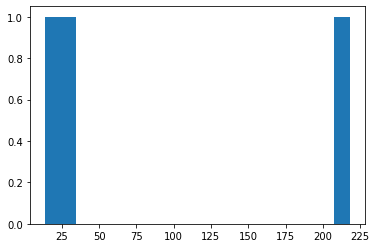

In [12]:
landing_azimuths = np.concatenate(list(landed_ids.values()))
plt.hist(landing_azimuths, bins=20)

(array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([2509.0, 2542.0, 2575.0, 2608.0, 2641.0, 2674.0, 2707.0, 2740.0,
        2773.0, 2806.0, 2839.0, 2872.0, 2905.0, 2938.0, 2971.0, 3004.0,
        3037.0, 3070.0, 3103.0, 3136.0, 3169.0], dtype=object),
 <a list of 20 Patch objects>)

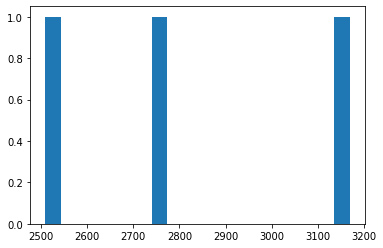

In [13]:
landing_durations = np.concatenate(list(landing_duration.values()))
plt.hist(landing_durations, bins=20)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([-1274.0, -1259.9, -1245.8, -1231.7, -1217.6, -1203.5, -1189.4,
        -1175.3, -1161.2, -1147.1, -1133.0, -1118.9, -1104.8, -1090.7,
        -1076.6, -1062.5, -1048.4, -1034.3, -1020.2, -1006.1, -992.0],
       dtype=object),
 <a list of 20 Patch objects>)

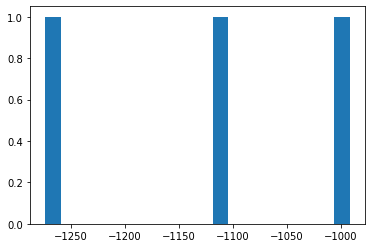

In [14]:
landing_duration_changes = np.concatenate(list(landing_duration_change.values()))
plt.hist(landing_duration_changes, bins=20)

In [ ]:
actual_durations = landing_durations - landing_duration_changes
plt.hist(actual_durations, bins=20)

In [ ]:
landing_durations = landing_durations[actual_durations > 1000]
plt.hist(landing_durations, bins=20)

In [ ]:
landing_duration_changes = landing_duration_changes[actual_durations > 1000]
plt.hist(landing_duration_changes, bins=20)

In [ ]:
actual_durations = actual_durations[actual_durations > 1000]
plt.hist(actual_durations, bins=20)

In [ ]:
landing_duration_changes.mean()

In [ ]:
import scipy.stats
scipy.stats.ttest_rel(a = actual_durations, b = landing_durations, nan_policy = 'omit')

In [ ]:
len(landed_ids)

In [ ]:
df1 = landing_ac_data[(landing_ac_data['ts'] >= start_ts) & (landing_ac_data['ts'] <= max_ts)]
df1 = df1[['id', 'jfk_landing_flag']].groupby(['id']).any()
df1.sum()

In [ ]:
# conflicts = pd.concat(conflict_xyz, axis = 0).reset_index(drop = True)
# conflicts['pos'] = conflicts.apply(lambda x: tuple(x), axis = 1)
# conflicts['pos'].value_counts()

In [ ]:
# current_other_df = last_known_other_df.apply(lambda x: get_current_pos(x, df['ts']), axis = 1)
# current_other_df_xyz = current_other_df.apply(lambda x: convert_pos_to_xyz_new(x, x_max, y_max, z_max))
# current_other_df_xyz.head()

In [ ]:
# # collisions = current_df_xyz.apply(lambda x: check_collision(x, current_df_xyz))
# collisions = current_df_xyz.apply(lambda x: check_collision(x, current_df_xyz))
# last_known_df[(last_known_df['z'] > 2) & (collisions > 0)]

In [ ]:
# last_known_landing_df.head()

In [ ]:
# current_df_xyz.head() == current_df_xyz.iloc[0]

In [ ]:
# current_df_xyz.iloc[0]

In [ ]:
# last_known_landing_df.columns

In [ ]:
# max_ts = chosen_ts + max_time
# ts1 = chosen_ts
# flight_data1 = flight_data[~flight_data['jfk_landing_flag']]
# landing_ac_data = landing_ac_data[(landing_ac_data['date'] == chosen_dt) & (landing_ac_data['id_end_ts'] >= chosen_ts)]
# start_time = time.time()
# gc.collect()
# # cores = mp.cpu_count() - 1

# def get_next_xyzs(x, y, z):
#     return (list(transitions1_xyz[(x, y, z)].keys()))

# last_known_other_df = flight_data1[(flight_data1['id_start_ts'] <= ts1) & (flight_data1['id_end_ts'] >= ts1)]
# last_known_other_df = last_known_other_df.sort_values(['id', 'ts']).reset_index(drop = True)
# last_known_other_df = last_known_other_df[last_known_other_df['ts'] <= ts1].groupby(['id']).last()
# last_known_landing_df = landing_ac_data[(landing_ac_data['id_start_ts'] <= ts1) & (landing_ac_data['id_end_ts'] >= ts1)]
# last_known_landing_df = last_known_landing_df[(last_known_landing_df['ts'] <= ts1) & (last_known_landing_df['ground_flag'] != 1)].groupby(['id']).last()
# last_known_landing_df["dist_from_airport"] = last_known_landing_df.apply(lambda x: get_distance_from_airport(x, airport_coords), axis = 1)
# last_known_landing_df = last_known_landing_df.sort_values(['dist_from_airport']).reset_index(drop = True)
# last_known_landing_df = append_xyz(landing_ac_data = last_known_landing_df, x_max = x_max, y_max = y_max, z_max = z_max)
# last_known_landing_df['list_grSpd_azi'] = last_known_landing_df.apply(lambda x: get_next_xyzs(x['x'], x['y'], x['z']), axis = 1)
# last_known_landing_df['nearest_ground_speed_azimuth'] = np.empty((last_known_landing_df.shape[0], 0)).tolist()
# # i = 0
# # df = last_known_landing_df.iloc[i]
# print(df)
# df = greedy_update_df(df, airport_coords, transitions1_xyz, delta_ts1)
# print(df)

In [ ]:
# print(df['ts'])
# print(ts1)

In [ ]:
# print(gr_spd_azi)
# print(delta_ts)

In [ ]:
# next_ts

In [ ]:
# next_gr_spd_azi

In [ ]:
# for i in range(1, last_known_landing_df.shape[0]):
#     df1 = last_known_landing_df.iloc[i]
#     delta_ts = 0
#     while (delta_ts + df1['ts']) < df['ts']:
#         nearest_ground_speed_azimuth = get_nearest_ground_speed_azimuth(df1['ground_speed'], df1['azimuth'], list_grSpd_azi = df1['list_grSpd_azi'])
#         actions, temp_delta_ts, next_xyzs = get_next_state(df = df1, transitions1_xyz = transitions1_xyz, nearest_ground_speed_azimuth = nearest_ground_speed_azimuth)
#         actions = pd.concat(pd.Series(list(actions.keys())).apply(pd.DataFrame).tolist(), axis = 1).T
#         actions.columns = ['x', 'y', 'z']
#         next_xyz = tuple(get_greedy_action(actions, airport_coords))
#         next_gr_spd_azi = delta_ts1[(df1['x'], df1['y'], df1['z'])][nearest_ground_speed_azimuth][next_xyz].keys()
#         next_ts = delta_ts1[(df1['x'], df1['y'], df1['z'])][nearest_ground_speed_azimuth][next_xyz]
#         delta_times = list(next_ts.values())
#         delta_times = list(itertools.chain(*delta_times))
#         delta_ts = int(min(delta_times))
#         if (delta_ts + df1['ts'] < df['ts']):
#             gr_spd_azis = [[keys] * len(next_ts[keys]) for keys in next_ts.keys()]
#             gr_spd_azi = list(itertools.chain(*gr_spd_azis))
#             gr_spd_azi = gr_spd_azi[delta_times.index(delta_ts)]
            
#             # Update time, position, ground speed, azimuth, next set of positions
#             df1['ts'] = df1['ts'] + delta_ts
#             df1['ground_speed'] = gr_spd_azi[0]
#             df1['azimuth'] = gr_spd_azi[1]
#             df1['x'] = next_xyz[0]
#             df1['y'] = next_xyz[1]
#             df1['z'] = next_xyz[2]
#             df1['list_grSpd_azi'] = get_next_xyzs(df1['x'], df1['y'], df1['z'])

In [ ]:
# i = 1
# df1 = last_known_landing_df.iloc[i]
# df2 = df1.copy(deep = True)
# delta_ts2 = 0
# while df2['ts'] <= df['ts']:
#     nearest_ground_speed_azimuth = get_nearest_ground_speed_azimuth(df1['ground_speed'], df1['azimuth'], list_grSpd_azi = df1['list_grSpd_azi'])
#     actions, temp_delta_ts, next_xyzs = get_next_state(df = df1, transitions1_xyz = transitions1_xyz, nearest_ground_speed_azimuth = nearest_ground_speed_azimuth)
#     actions = pd.concat(pd.Series(list(actions.keys())).apply(pd.DataFrame).tolist(), axis = 1).T
#     actions.columns = ['x', 'y', 'z']
#     next_xyz = tuple(get_greedy_action(actions, airport_coords))
#     next_gr_spd_azi = delta_ts1[(df1['x'], df1['y'], df1['z'])][nearest_ground_speed_azimuth][next_xyz].keys()
#     next_ts = delta_ts1[(df1['x'], df1['y'], df1['z'])][nearest_ground_speed_azimuth][next_xyz]
#     delta_times = list(next_ts.values())
#     delta_times = list(itertools.chain(*delta_times))
#     delta_ts2 = int(min(delta_times))
#     gr_spd_azis = [[keys] * len(next_ts[keys]) for keys in next_ts.keys()]
#     gr_spd_azi = list(itertools.chain(*gr_spd_azis))
#     gr_spd_azi = gr_spd_azi[delta_times.index(delta_ts2)]
#     # Update time, position, ground speed, azimuth, next set of positions
#     df2['ts'] = df2['ts'] + delta_ts2
#     df2['ground_speed'] = gr_spd_azi[0]
#     df2['azimuth'] = gr_spd_azi[1]
#     df2['x'] = next_xyz[0]
#     df2['y'] = next_xyz[1]
#     df2['z'] = next_xyz[2]
#     df2['list_grSpd_azi'] = get_next_xyzs(df2['x'], df2['y'], df2['z'])
#     if (df2['ts'] <= df['ts']):
#         df1 = df2.copy(deep = True)

In [ ]:
# # i = 1
# # df1 = last_known_landing_df.iloc[i]
# # delta_ts = 0
# # print(df1)
# nearest_ground_speed_azimuth = get_nearest_ground_speed_azimuth(df1['ground_speed'], df1['azimuth'], list_grSpd_azi = df1['list_grSpd_azi'])
# actions, temp_delta_ts, next_xyzs = get_next_state(df = df1, transitions1_xyz = transitions1_xyz, nearest_ground_speed_azimuth = nearest_ground_speed_azimuth)
# actions = pd.concat(pd.Series(list(actions.keys())).apply(pd.DataFrame).tolist(), axis = 1).T
# actions.columns = ['x', 'y', 'z']
# next_xyz = tuple(get_greedy_action(actions, airport_coords))
# next_gr_spd_azi = delta_ts1[(df1['x'], df1['y'], df1['z'])][nearest_ground_speed_azimuth][next_xyz].keys()
# next_ts = delta_ts1[(df1['x'], df1['y'], df1['z'])][nearest_ground_speed_azimuth][next_xyz]
# delta_times = list(next_ts.values())
# delta_times = list(itertools.chain(*delta_times))
# delta_ts = int(min(delta_times))
# if (delta_ts + df1['ts'] < df['ts']):
#     gr_spd_azis = [[keys] * len(next_ts[keys]) for keys in next_ts.keys()]
#     gr_spd_azi = list(itertools.chain(*gr_spd_azis))
#     gr_spd_azi = gr_spd_azi[delta_times.index(delta_ts)]

#     df1['ts'] = df1['ts'] + delta_ts
#     df1['ground_speed'] = gr_spd_azi[0]
#     df1['azimuth'] = gr_spd_azi[1]
#     df1['x'] = next_xyz[0]
#     df1['y'] = next_xyz[1]
#     df1['z'] = next_xyz[2]
#     df1['list_grSpd_azi'] = get_next_xyzs(df1['x'], df1['y'], df1['z'])

# # print(df1)

In [ ]:
# delta_ts

In [ ]:
#     last_known_landing_df['nearest_ground_speed_azimuth'] = np.empty((last_known_landing_df.shape[0], 0)).tolist()
#     last_known_landing_df['nearest_ground_speed_azimuth'] = last_known_landing_df.apply(lambda df: get_nearest_ground_speed_azimuth(df['ground_speed'], df['azimuth'], list_grSpd_azi = df['list_grSpd_azi']), axis = 1)
#     last_known_other_df = append_xyz(landing_ac_data = last_known_other_df, x_max = x_max, y_max = y_max, z_max = z_max)
#     for i in range(last_known_landing_df.shape[0]):
#         df = last_known_landing_df.iloc[i]
#         nearest_ground_speed_azimuth = get_nearest_ground_speed_azimuth(df['ground_speed'], df['azimuth'], list_grSpd_azi = df['list_grSpd_azi'])
#         actions, temp_delta_ts, next_xyzs = get_next_state(df = df, trainsitions1_xyz, nearest_ground_speed_azimuth)


In [ ]:
# len(landing_ac_data[landing_ac_data['date'] == chosen_dt]['id'].unique())

In [ ]:
# flight_data1['ground_flag'].sum()

In [ ]:
# print(flight_data.shape)
# print(flight_data1.shape)

# Run simulation of 1 aircraft

In [ ]:
transitions1_xyz = pickle.load(open("transitions1_xyz_" + str(x_max) + "_" + str(y_max) + "_" + str(z_max) + "_multi_dict.pkl", "rb"))
delta_ts1 = pickle.load(open("delta_ts1_" + str(x_max) + "_" + str(y_max) + "_" + str(z_max) + "_multi_dict.pkl", "rb"))
landed_xyz = pickle.load(open("landed_xyz.pkl", "rb"))
time_to_land1_xyz = pickle.load(open("time_to_land1_" + str(x_max) + "_" + str(y_max) + "_" + str(z_max) + "_multi_dict.pkl", "rb"))
landing_value1_xyz = pickle.load(open("landing_value1_" + str(x_max) + "_" + str(y_max) + "_" + str(z_max) + "_multi_dict.pkl", "rb"))

In [ ]:
def check_collision(pos, reference, current_included = True):
    return (int(pos == reference) - current_included)


def simulate_single_aircraft_landing(df):
    landed = False
    total_time = 0
    path = []
    while not landed:
#         try:
        path.append((df['x'], df['y'], df['z']))
        ts1 = df['ts']
        # We will not be able to know the complete duration of chosen aircraft before it actually lands
        temp_flight_data = flight_data[(flight_data['id_start_ts'] <= ts1) &
                                       (flight_data['id_end_ts'] >= ts1) &
                                       (flight_data['id'] != chosen_id)]
        last_known_df = temp_flight_data[temp_flight_data['ts'] <= ts1].reset_index(drop = True).groupby(['id']).last().reset_index(drop = False)
        last_known_df = last_known_df[(last_known_df['altitude'] > 0) | (last_known_df['climb_rate'] != 0)].reset_index(drop = True)
        current_df = last_known_df.apply(lambda x: get_current_pos(x, ts1), axis = 1)
        list_grSpd_azi = list(transitions1_xyz[(df['x'], df['y'], df['z'])].keys())
        nearest_ground_speed_azimuth = get_nearest_ground_speed_azimuth(df['ground_speed'], df['azimuth'], list_grSpd_azi = list_grSpd_azi)
        actions, temp_delta_ts, next_xyzs = get_next_state(df = df, transitions1_xyz = transitions1_xyz, nearest_ground_speed_azimuth = nearest_ground_speed_azimuth, delta_ts1 = delta_ts1)
#         actions = transitions1_xyz[(df['x'], df['y'], df['z'])][nearest_ground_speed_azimuth]
#         temp_delta_ts = delta_ts1[(df['x'], df['y'], df['z'])][nearest_ground_speed_azimuth]
#         next_xyzs = []
#         for key in actions.keys():
#             total = sum(list(actions[key].values()))
#             next_xyzs.append(repeat(key, total))
#         next_xyzs = unlist(next_xyzs)
        
        # This should probably change to greedy selection
        j = random.randint(a = 0, b = len(next_xyzs) - 1)
        next_xyz = next_xyzs[j]
        next_ground_speed_azimuth = list(actions[next_xyz].keys())
        j = random.randint(a = 0, b = len(next_ground_speed_azimuth) - 1)
        next_ground_speed_azimuth = next_ground_speed_azimuth[j]
        all_delta_ts = temp_delta_ts[next_xyz][next_ground_speed_azimuth]
        
        # This should probably change to greedy selection
        j = random.randint(a = 0, b = len(all_delta_ts) - 1)
        temp_delta_ts = all_delta_ts[j]
        df['ts'] = df['ts'] + temp_delta_ts
    #     previous_state = ((df['x'], df['y'], df['z']), (df['ground_speed'], df['azimuth']))
        total_time += temp_delta_ts
        df['x'] = next_xyz[0]
        df['y'] = next_xyz[1]
        df['z'] = next_xyz[2]
        df['ground_speed'] = next_ground_speed_azimuth[0]
        df['azimuth'] = next_ground_speed_azimuth[1]
        path.append(next_xyz)
        landed = (df['x'], df['y'], df['z']) in landed_xyz
        current_xyz = current_df.apply(convert_pos_to_xyz)
        collisions = current_xyz.apply(lambda x: check_collision(x, (df['x'], df['y'], df['z'])))
        if collisions.sum() > 0:
            print("Collision cannot be avoided between " + last_known_df['id'][collisions] + " and " + df['id'] + " at " + str(ts1))
            break
#         except:
#             break
    return [path, total_time]


def simulate_single_aircraft_landing_i(i):
    return simulate_single_aircraft_landing(df)

In [ ]:
landing_ac_data = pd.read_csv("../../landing_samples.csv",
                              dtype = {"date": str, "id": str, "lat": np.float16,
                                       "lon": np.float16, "ts": np.int32, "altitude": np.int32,
                                       "climb_rate": np.int16, "azimuth": np.int16,
                                       "ground_speed": np.int16, "jfk_landing_flag": bool,
                                       "source": str, "destination": str, "ground_flag": bool,
                                       "x": np.int8, "y": np.int8, "z": np.int8,
                                       "id_start_ts": np.int32, "id_end_ts": np.int32},
                              usecols = ["date", "id", "lat", "lon", "ts", "altitude", "climb_rate",
                                         "azimuth", "ground_speed", "jfk_landing_flag",
                                         "source", "destination", "ground_flag", "x", "y",
                                         "z", "id_start_ts", "id_end_ts"])
landing_ac_data = append_xyz(landing_ac_data, x_max, y_max, z_max)
landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)
# landing_ac_data.drop(['id_start_ts', 'id_end_ts'], axis = 1)
first_df = landing_ac_data[['id', 'ts']].groupby(['id']).first().reset_index(drop = False)
last_df = landing_ac_data[['id', 'ts']].groupby(['id']).last().reset_index(drop = False)
first_df.columns = ['id', 'id_start_ts']
last_df.columns = ['id', 'id_end_ts']
landing_ac_data = landing_ac_data.merge(first_df)
landing_ac_data = landing_ac_data.merge(last_df)
landing_ac_data = landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)

In [ ]:
# Simulating landing of 1 aircraft
uniq_id = landing_ac_data['id'].unique()
max_landings = 1
# i = random.randint(a = 0, b = len(uniq_id) - 1)

start_time = time.time()
for i in [0,8]:
    chosen_id = uniq_id[i]
    # chosen_id = "A3F04A_0"
    dt = landing_ac_data['date'][landing_ac_data['id'] == chosen_id].iloc[0]
    print(dt)
    flight_data = pd.read_csv("../../" + dt + ".csv", header = None)
    tmp_dat = pd.read_csv("../../samples_with_jfk_landing_flag.csv", nrows = 1)
    flight_data.columns = tmp_dat.columns

    flight_data.sort_values(['id', 'ts']).reset_index(drop = True)
    flight_data.drop(['id_start_ts', 'id_end_ts'], axis = 1)
    first_df = flight_data[['id', 'ts']].groupby(['id']).first().reset_index(drop = False)
    last_df = flight_data[['id', 'ts']].groupby(['id']).last().reset_index(drop = False)
    first_df.columns = ['id', 'id_start_ts']
    last_df.columns = ['id', 'id_end_ts']
    flight_data = flight_data.merge(first_df)
    flight_data = flight_data.merge(last_df)
    flight_data = flight_data.sort_values(['id', 'ts']).reset_index(drop = True)
    flight_data = append_xyz(flight_data, x_max, y_max, z_max)
    df = landing_ac_data[landing_ac_data['id'] == chosen_id].sort_values(['ts']).reset_index(drop = True).iloc[0]
#     print(df)
    landings = 0
    
    cores = max_landings
    p = mp.Pool(processes = cores)
    split_dfs = np.array_split([i for i in range(cores)], cores)
    pool_results = p.map(simulate_single_aircraft_landing_i, split_dfs)
    p.close()
    p.join()
    
    times = []
    for i in range(len(pool_results)):
        res = pool_results[i]
        path = res[0]
        tim = res[1]
        times.append(tim)
        mat = np.zeros((flight_data['x'].max()+1, flight_data['y'].max()+1, flight_data['z'].max()+1))
        for coord in path:
            mat[coord[0], coord[1], coord[2]] += 1

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        pos = np.where(mat > 0)
        ax.plot(pos[0], pos[1], pos[2], c='black')
        ax.scatter([85], [113], [0], c = 'red')
        plt.title("Example simulation")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()
    
    min_times = min(min(times), df['id_end_ts'] - df['id_start_ts'])
    max_times = max(max(times), df['id_end_ts'] - df['id_start_ts'])
    plt.hist(10000 - np.array(times), bins = 80, range = (10000-max_times, 10000-min_times))
    plt.title("Distribution of rewards (10 simulations)")
    plt.axvline(10000 - (df['id_end_ts'] - df['id_start_ts']), color='red', linestyle='dashed', linewidth=1)
    plt.show()

end_time = time.time()
print(end_time - start_time)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pos = np.where(mat > 0)
ax.plot(pos[0], pos[1], pos[2], c='black')
ax.scatter([85], [113], [0], c = 'red')
plt.title("Example simulation")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [ ]:
min_times = min(min(times), df['id_end_ts'] - df['id_start_ts'])
max_times = max(max(times), df['id_end_ts'] - df['id_start_ts'])
plt.hist(10000 - np.array(times), bins = 80, range = (10000-max_times, 10000-min_times))
plt.title('Distribution of rewards for example 1')
plt.axvline(10000 - (df['id_end_ts'] - df['id_start_ts']), color='red', linestyle='dashed', linewidth=1)
plt.show()

In [ ]:
gc.collect()